In [ ]:
import requests
import yaml
from bs4 import BeautifulSoup
import json
from concurrent.futures import ThreadPoolExecutor

with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)
    
def getData(urlchotot):
    response = requests.get(url=urlchotot)
    soup = BeautifulSoup(response.text, 'html.parser')
    all_results = soup.find_all('div', attrs={'tabindex':"0"})
    for result in all_results:
        data = {}
        data["name"] = result.find('h3',class_="adonovt").text
        data["year"] = result.find('span', class_='c1u6gyxh').text
        data["price"] = result.find('span', class_='bfe6oav').text
        newRequest = requests.get("https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href'))
        newSoup = BeautifulSoup(newRequest.text, 'html.parser')
        data["description"] = newSoup.find('p', attrs={'itemprop':'description'}).text
        data["urlcar"] = "https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href')
        print(json.dumps(data, ensure_ascii=False, indent=2))

def main():
    urlchotot = config['url']['urlchotot']
    listUrl = [urlchotot.format(i) for i in range(1, 1000)]

    with ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(getData, listUrl)

if __name__ == '__main__':
    main()


In [ ]:
from Utils.postgres_tool import PostgresTool
import yaml
with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)

db_params = config['database']
# import psycopg2
# try:
#     connection = psycopg2.connect(**db_params)
#     cursor = connection.cursor()
    
#     # Execute a simple query
#     cursor.execute("SELECT version();")
#     record = cursor.fetchone()
#     print("You are connected to - ", record, "\n")
    
#     # Close the cursor and connection
#     cursor.close()
#     connection.close()
# except Exception as error:
#     print("Error while connecting to PostgreSQL", error)
conn = PostgresTool(**db_params)
conn.get_all_table()

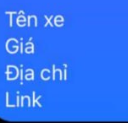

In [7]:
import requests
import yaml
from bs4 import BeautifulSoup
import json
import time
import redis

with open('./config/config.yml', 'r') as f:
    config = yaml.safe_load(f)

redis_sv = config['redis_sv']
print(redis_sv)
redis_client = redis.Redis(**redis_sv)

def getData(urlchotot):
    response = requests.get(url=urlchotot)
    soup = BeautifulSoup(response.text, 'html.parser')
    all_results = soup.find_all('div', attrs={'tabindex':"0"})
    redis_set_key = "carchotot"

    for result in all_results:
        newRequest = requests.get("https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href'))
        newSoup = BeautifulSoup(newRequest.text, 'html.parser')
        data = {}
        data["name"] = newSoup.find('h1').text
        data["price"] = newSoup.find('b', class_='p26z2wb').text
        data["address"] = newSoup.find('span', class_ = "bwq0cbs flex-1").text
        data["urlcar"] = "https://xe.chotot.com"+result.find('a',attrs={'itemprop':'item'}).get('href')
        redis_key = f"{data}" 
        exists = redis_client.sismember(redis_set_key, str(data))
        if not exists:
            redis_client.sadd(redis_set_key, str(data))
            redis_client.expire(redis_set_key, 60*60*24)
            redis_client.setex(redis_key, 60*60*24, str(data))

            data = {k: (v if v != "None" else None) for k, v in data.items()}
            print(json.dumps(data, ensure_ascii=False, indent=2))
            # send data telegram message
        else:
            pass

def main():
    urlchotot = config['url']['urlchotot']
    listUrl = [urlchotot.format(i) for i in range(1, 10)]
    for url in listUrl: 
        getData(url)

if __name__ == '__main__':
    while True:
        main()
        # time.sleep(30*60) # 30 p
        time.sleep(2)


{'host': 'localhost', 'port': 6377, 'db': 0}
{
  "name": "Hãng bán Ford Ecosport Tita 2018 lướt 23.000 km",
  "price": "450.000.000 đ",
  "address": "Phường 3, Quận 3, Tp Hồ Chí Minh",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-quan-3-tp-ho-chi-minh/118249700.htm#px=SR-stickyad-[PO-1][PL-top]"
}
{
  "name": "cần bán xe Fortuner số tự động, máy dầu, 2 cầu",
  "price": "395.000.000 đ",
  "address": "Phường Thạnh Lộc, Quận 12, Tp Hồ Chí Minh",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-quan-12-tp-ho-chi-minh/118355699.htm#px=SR-stickyad-[PO-2][PL-top]"
}
{
  "name": "Hyundai Accent 2011 1.4 AT - 113000 km",
  "price": "280.000.000 đ",
  "address": "Phường Vĩnh Phú, Thành phố Thuận An, Bình Dương",
  "urlcar": "https://xe.chotot.com/mua-ban-oto-thanh-pho-thuan-an-binh-duong/118369332.htm#px=SR-stickyad-[PO-3][PL-top]"
}
{
  "name": "Toyota Innova E 2013",
  "price": "290.000.000 đ",
  "address": "Phường Đại Kim, Quận Hoàng Mai, Hà Nội",
  "urlcar": "https://xe.chotot.com/mua-ban-ot

In [4]:
from messageTelegram.app import potsMessage
data = {
    "name": "Hyundai Starex Van 2.5 MT - 2005",
    "year": "2005",
    "price": " 97 Triệu ",
    "description": " *Xe nhập khẩu, màu đen, máy dầu 2.5 L, số tay, 6 chỗ ... Hyundai Starex 2005 máy dầu 6 chỗ 800kg xe đẹp máy êm ko khói đhoa cực mát xe cc miễn TG ",
    "urlcar": "https://bonbanh.com/xe-hyundai-starex-van-2.5-mt-2005-5571723",
    "location": "Phường Hố Nai, Thành phố Biên Hòa, Đồng Nai"
}

(potsMessage(data))


<coroutine object potsMessage at 0x00000255C140F240>

In [2]:
asyncio.run(potsMessage(data))


C:\Users\obito\AppData\Local\Temp\ipykernel_4860\693254464.py:26: RuntimeWarning: coroutine 'Bot.send_message' was never awaited
  bot.send_message(
